In [ ]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds



load data

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-08-13 14:19:38--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-08-13 14:19:38--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-08-13 14:19:39--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted([os.path.join(input_dir, fname)for fname in os.listdir(input_dir)if fname.endswith(".jpg")])

In [ ]:
target_paths = sorted([os.path.join(target_dir, fname)for fname in os.listdir(target_dir)
if fname.endswith(".png") and not fname.startswith(".")])

visualize data

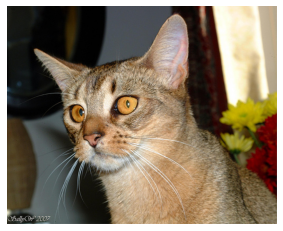

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array
plt.axis('off')
plt.imshow(load_img(input_img_paths[10]))

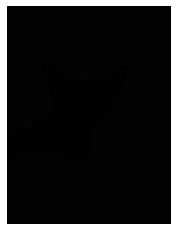

In [ ]:
plt.axis('off')
plt.imshow(load_img(target_paths[1]))

In [ ]:
img=img_to_array(load_img(target_paths[10], color_mode="grayscale"))
def display_target(target_array):
    normal_array=(target_array.astype("uint8")-1)*127
    plt.axis("off")
    plt.imshow(normal_array[:, :, 0])


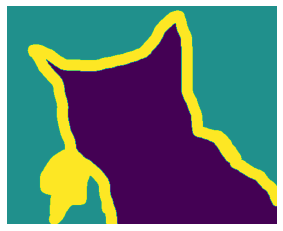

In [ ]:
display_target(img)

train test split

In [ ]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

In [ ]:
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
  img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8")-1
  return img

In [ ]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [ ]:
print(type(train_input_imgs))

<class 'numpy.ndarray'>


In [ ]:
train_input_imgs.shape

(6390, 200, 200, 3)

In [ ]:
train_targets.shape

(6390, 200, 200, 1)

In [ ]:
val_input_imgs.shape

(1000, 200, 200, 3)

In [ ]:
val_targets.shape

(1000, 200, 200, 1)

define  model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

  x=layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x=layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x=layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x=layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x=layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x=layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
  128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(
  64, 3, activation="relu", padding="same", strides=2)(x)
  outputs = layers.Conv2D(num_classes, 3, activation="softmax",
  padding="same")(x)
  model = keras.Model(inputs, outputs)
  return model
  
  


In [ ]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [ ]:
keras.backend.clear_session()

In [ ]:
val_input_imgs.shape

(1000, 200, 200, 3)

In [ ]:
val_targets.shape

(1000, 200, 200, 1)

In [ ]:
train_input_imgs.shape

(6390, 200, 200, 3)

In [ ]:
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy')
callbacks = [
keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
epochs=20,
callbacks=callbacks,
batch_size=64,
validation_data=(val_input_imgs, val_targets))

Epoch 1/20
100/100 [==============================] - 88s 692ms/step - loss: 1.0073 - val_loss: 0.9364
Epoch 2/20
100/100 [==============================] - 61s 607ms/step - loss: 0.9434 - val_loss: 0.9104
Epoch 3/20
100/100 [==============================] - 61s 612ms/step - loss: 0.8580 - val_loss: 0.8293
Epoch 4/20
100/100 [==============================] - 61s 614ms/step - loss: 0.8051 - val_loss: 0.6989
Epoch 5/20
100/100 [==============================] - 61s 614ms/step - loss: 0.7173 - val_loss: 0.7857
Epoch 6/20
100/100 [==============================] - 61s 613ms/step - loss: 0.6747 - val_loss: 0.6183
Epoch 7/20
100/100 [==============================] - 61s 613ms/step - loss: 0.6216 - val_loss: 0.5873
Epoch 8/20
100/100 [==============================] - 61s 614ms/step - loss: 0.5974 - val_loss: 0.5571
Epoch 9/20
100/100 [==============================] - 61s 614ms/step - loss: 0.5702 - val_loss: 0.5364
Epoch 10/20
100/100 [==============================] - 61s 613ms/step - l

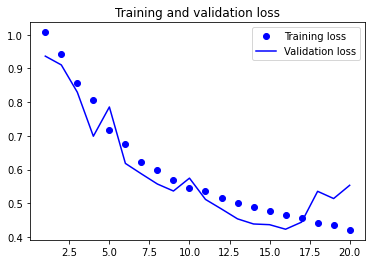

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

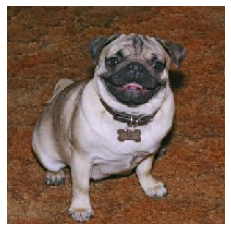

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
test_image = val_input_imgs[10]
plt.axis("off")
plt.imshow(array_to_img(test_image))



In [ ]:
test_image.shape

(200, 200, 3)

In [ ]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

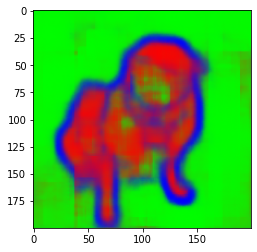

In [ ]:
plt.imshow(mask)

[  0 127 254]


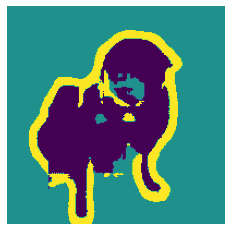

In [ ]:
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  print(np.unique(mask))
  plt.axis("off")
  plt.imshow(mask)
display_mask(mask)

In [ ]:
a=np.argmax(mask, axis=-1)*100
np.unique(a)

array([  0, 100, 200])

In [ ]:
a = np.where(a > 1,1, a) 
a=np.where(a==1,255,a)

In [ ]:
np.unique(a)

array([  0, 255])

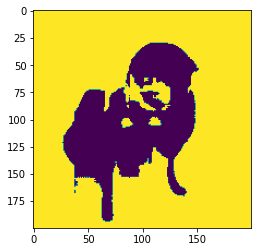

In [ ]:
plt.imshow(a)

In [ ]:
a.shape

(200, 200)

In [ ]:
import cv2

In [ ]:

blurred_original_image = cv2.GaussianBlur(test_image, (251,251), 0)
layered_image = np.where(a != (0,0,0), test_image,  blurred_original_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
